In [1]:
from IPython.display import clear_output
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from collections import namedtuple

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader, random_split
from torch.optim import Adam

In [3]:
from nn_utils import AE_3D_500cone_bn
from ae_utils import *

In [4]:
torch.cuda.is_available()

True

In [5]:
torch.backends.cudnn.enabled

True

In [6]:
PATH = 'data/4D/'
test_pickle = f'{PATH}all_jets_test_4D_100_percent.pkl'
train_pickle = f'{PATH}all_jets_train_4D_100_percent.pkl'

## Play with the dataset

In [7]:
train_df = pd.read_pickle(train_pickle)

In [8]:
train_df.shape

(111778, 4)

In [9]:
train_df.sample(5)

,m,pt,phi,eta
84934,5561.729980,27725.820312,2.560772,-0.453464
127942,14105.796875,113329.304688,-0.466553,1.075109
95872,23378.501953,179594.140625,2.355374,0.335487
93534,5963.377930,28249.710938,2.473990,-1.293478
96974,4849.878418,21249.873047,1.992374,-0.236806


In [10]:
train_df_normalised = ((train_df - train_df.min())/(train_df.max() - train_df.min()))
train_df_normalised.sample(5)

,m,pt,phi,eta
83554,0.157004,0.140676,0.114361,0.498646
39024,0.045431,0.009411,0.323587,0.481504
139475,0.170856,0.183317,0.645628,0.582322
9482,0.149013,0.152872,0.108840,0.558447
114598,0.039180,0.008222,0.056025,0.357668


In [11]:
train_df_normalised.values.shape

(111778, 4)

## Initialise

In [12]:
# Hyperparameters
num_epochs = 100
batch_size = 128
weight_decay = 1e-6
learning_rate = 1e-4

In [13]:
# Ratio to split the dataset into Training and Validation sets
train_ratio = 0.8

# Initialise the datasets
tv_dataset = AllJetsDataset(train_pickle)

train_size = int(len(tv_dataset) * train_ratio)
validation_size = len(tv_dataset) - train_size
train_dataset, validation_dataset = random_split(tv_dataset, [train_size, validation_size])

# Initialise the test dataset
test_dataset = AllJetsDataset(test_pickle)

datasets = Datasets(train_dataset, validation_dataset, test_dataset)

In [14]:
# Initialise the model
autoencoder = AE_3D_500cone_bn().cuda()

# Use a Mean Squared Error loss
loss_func = LossFunction(nn.MSELoss(), 'MSE')

# Use the Adam Optimiser
optimiser = Adam(autoencoder.parameters(), lr=learning_rate, weight_decay=weight_decay)

## Initialise Trainer

In [15]:
trainer = AE_Trainer(
    autoencoder=autoencoder, 
    datasets=datasets, 
    loss_func=loss_func, 
    optimiser=optimiser, 
    num_epochs=num_epochs,
    batch_size=batch_size)

## Train

In [16]:
trainer.train()

Training AE_3D_500cone_bn | Epoch: 100%|██████████| 100/100 [06:20<00:00,  3.80s/it, Train_Loss=0.0155, Validation_Loss=0.0117]


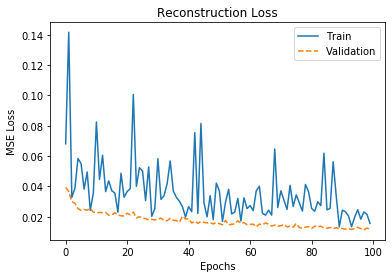

In [17]:
trainer.plot_reconstruction_loss()

## Test

In [18]:
trainer.test()

Test loss is:  0.011998518370091915


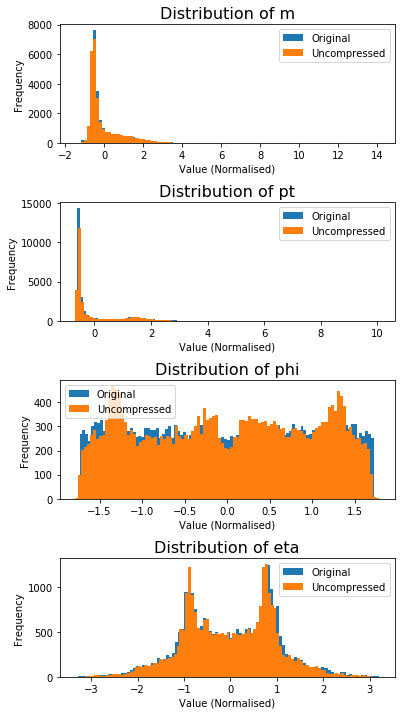

In [19]:
trainer.plot_test_reconstruction_distribution()

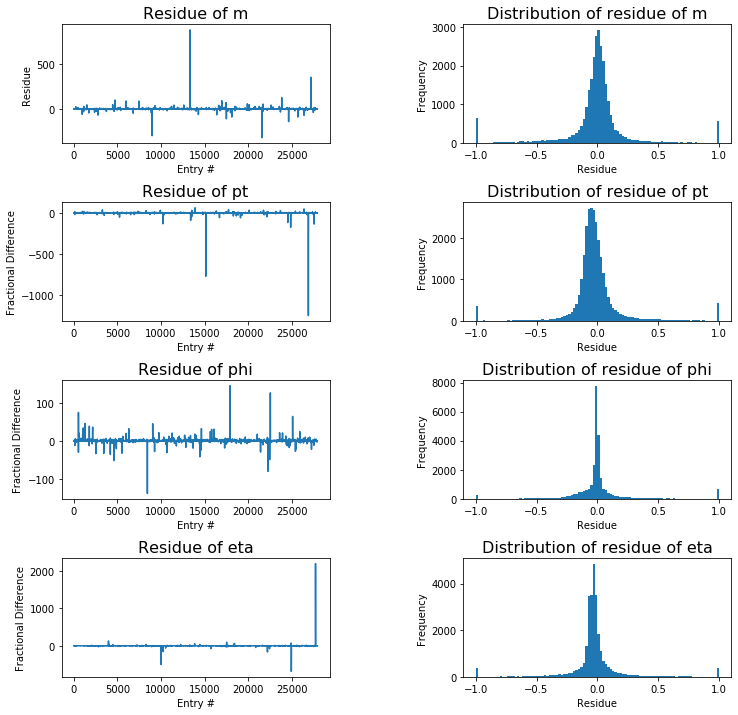

In [20]:
trainer.plot_test_residue_graphs()